# Monte Carlo in more than one dimension

## Takeaways and objectives from this notebook
1. Monte Carlo may be ineffective in higher-dimensional models. This motivates the Markov Chain MC approach.
2. We will observe numerical problems that appear when the (unnormalized) model posterior becomes too small, which motivates operating in logarithmic space.

Note: this notebook is heavily inspired by the talk [1], which discusses Markov Chain Monte Carlo and should be considered extra listening material.

## Monte Carlo in linear regression with Laplace prior
Imagine that we would want to use a standard Monte Carlo method for a higher-dimensional problem, for example for a simple linear regression with with Laplace priors, an example inspired by [1].

$$\begin{array}{rcl}
  y &=& \beta_1*x+\beta_2+\epsilon\\
  \beta_1 &\sim& \text{Laplace}(0,1) \\
  \beta_1 &\sim& \text{Laplace}(0,1) \\
  \epsilon &\sim& {\cal N}(0,1) \\
\end{array}$$

Incidentally using [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) priors centered on zero (see below) is equivalent to imposing an $L_1$ penalty (regularization) on the linear regression.

In the following example, we don't use PyMC3 but rather write the likelihood and prior term explicitly.

## Specifying the model

In this case, we also demonstrate sampling from a distribution using transformations from a simpler distribution.  Instead of directly using `numpy.random.laplace`, we use `numpy.random.rand` to draw uniformly distributed numbers in $[0,1)$ and transform them into Laplace distributed numbers in the function `draw_betas`.

The function `prior` computes the prior probability of the samples that we have drawn by evaluating the [Laplace density](https://en.wikipedia.org/wiki/Laplace_distribution). Note that the normalizing constant is evaluated as well.

The function `likelihood` evaluates the data likelihood under the assumed noise model - again this function is properly normalized.

Finally the `model_posterior_unnorm` returns the product of the two functions above but isn't properly normalized because it's not divided by the model evidence.

Note that in PyMC3, all these functions are implemented in the logarithmic space already, meaning that the products become sums and the exponential terms disappear.

In [ ]:
def draw_betas(n):
    # draw a from (-1/2, 1/2]
    u = -np.random.rand(n*2) + 0.5
    betas = - np.sign(u)*np.log(1-2*np.abs(u))
    return betas.reshape([n, 2])
    
def prior(betas):
    beta1_lk = 0.5 * np.exp(-np.abs(betas[0]-0.))
    beta2_lk = 0.5 * np.exp(-np.abs(betas[1]-0.))
    return beta1_lk * beta2_lk

def data_likelihood(betas, x, y):
    errors = y - (betas[0] * x + betas[1]) 
    return np.prod(np.exp(-0.5 * errors**2))

def model_posterior_unnorm(betas, x, y):
    return prior(betas) * data_likelihood(betas, x, y)

### Data
Manufacture data for our model for which we will compute the likelihood. We assume that the actual values are $\beta_1=2$ and $\beta_2=1$.

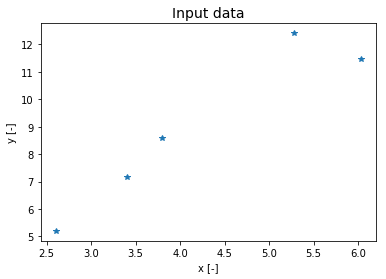

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_pts = 5

np.random.seed(124324)

# randomly generated x data - nothing to do with model
x = 2*np.random.randn(n_pts)+4

# y data are generated from model specified above with beta_1 = 2 and beta_2 = 1
y = 2*x+1+np.random.randn(n_pts)

plt.plot(x, y, '*')
plt.title('Input data', fontsize=14)
plt.xlabel('x [-]')
_ = plt.ylabel('y [-]')

In [3]:
np.random.seed(12345)

### Drawing $\beta_{1,2}$ candidates
We use our `draw_betas` function to obtain 15 samples from our prior and plot the resulting model in the context of our data.  Examine the 15 plots below.  Note that likelihood equal to zero happens whenever the likelihood underflows.

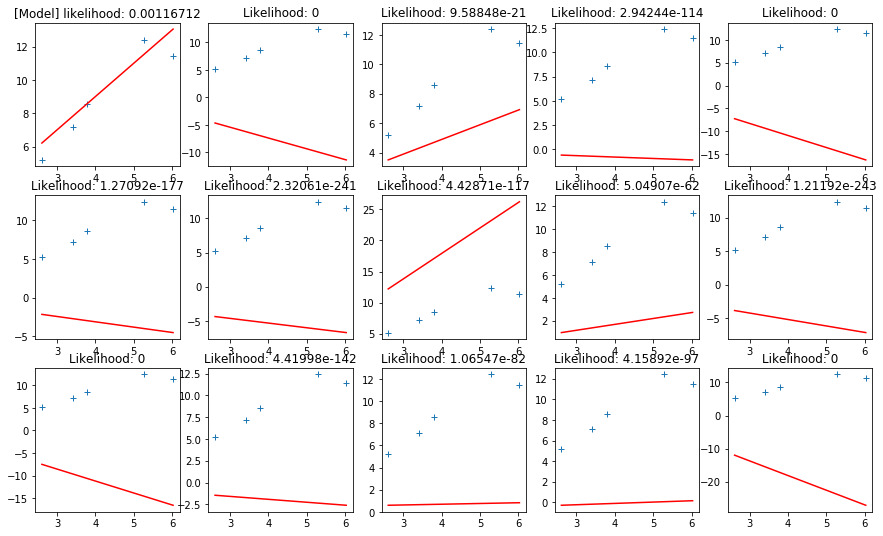

In [4]:
plt.figure(figsize=(15, 9))
plt.subplot(3,5,1)
plt.plot(x, y, '+')
plt.plot([min(x), max(x)], [2.*min(x)+1., 2.*max(x)+1.], 'r-')
plt.title('[Model] likelihood: %g' % model_posterior_unnorm([2., 1.], x, y))

for i, betas_i in enumerate(draw_betas(14)):
    plt.subplot(3, 5, i+2)
    plt.plot(x, y, '+')
    plt.plot([min(x), max(x)], [betas_i[0]*min(x)+betas_i[1], betas_i[0]*max(x)+betas_i[1]], 'r-')
    plt.title('Likelihood: %g' % model_posterior_unnorm(betas_i, x, y))

### Interpreting the plots
In general already for a two dimensional model, most of the samples have extremely small likelihood compared to the likelihood of the actual model, which is shown below.  This means we are sampling extremely low probability regions almost all the time.

## The prior density
Let us plot the prior density to see where the 




In [5]:
# first we setup the grid
xlim, ylim = (-10, 10), (-10, 10)
xg, yg = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(xlim[0], xlim[1], 100))
zg = np.zeros_like(xg)

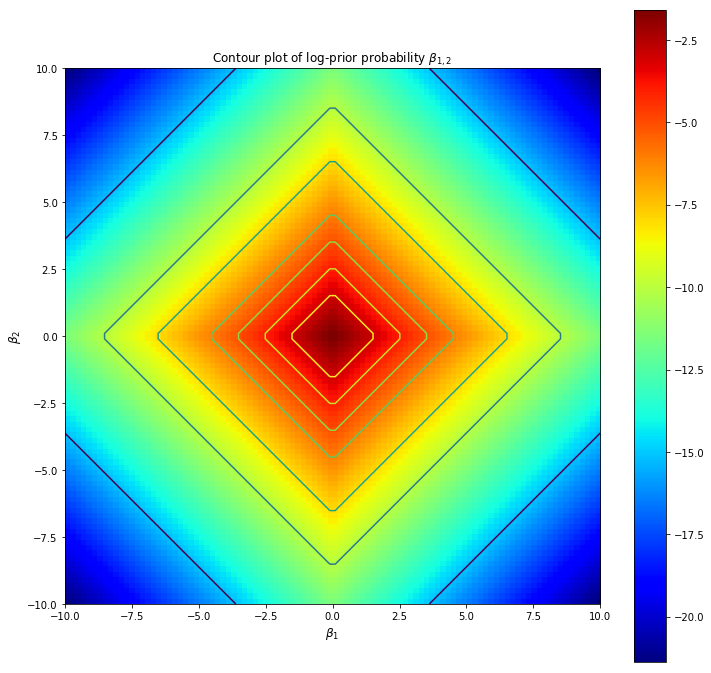

In [6]:
for i,j in np.ndindex(xg.shape):
    zg[i,j] = np.log(prior([xg[i,j], yg[i,j]]))
    
plt.figure(figsize=(12, 12))
plt.contour(xg, yg, zg, levels=[-15,-10, -8, -6, -5, -4, -3])
plt.imshow(zg, cmap='jet', extent=(xlim[0], xlim[1], ylim[0], ylim[1]), origin='lower')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.colorbar()
plt.title('Contour plot of log-prior probability $\\beta_{1,2}$')
plt.xlabel('$\\beta_1$', fontsize=12)
plt.ylabel('$\\beta_2$', fontsize=12)
_ = plt.show()

## The posterior density
Since the problem is only two dimensional, we can plot the log-probability of the density easily.  We clearly see where the data likelihood is high.

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


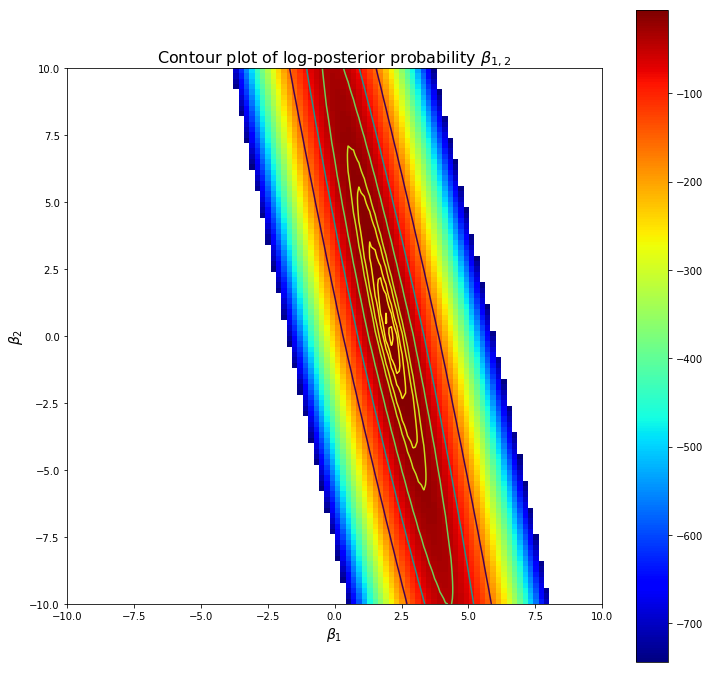

In [7]:
# re-use same data
for i,j in np.ndindex(xg.shape):
    zg[i,j] = np.log(model_posterior_unnorm([xg[i,j], yg[i,j]], x, y))

plt.figure(figsize=(12, 12))
plt.contour(xg, yg, zg, levels=[-160, -80, -40, -20, -15,-10, -8, -6, -5, -4, -3])
plt.imshow(zg, cmap='jet', extent=(xlim[0], xlim[1], ylim[0], ylim[1]), origin='lower')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.colorbar()
plt.title('Contour plot of log-posterior probability $\\beta_{1,2}$', fontsize=16)
plt.xlabel('$\\beta_1$', fontsize=14)
plt.ylabel('$\\beta_2$', fontsize=14)
_ = plt.show()

However observe that we get the warning of dividing by zero when plotting the following graph.  Even with 4 data points, the likelihood for bad guesses drops toward zero so fast that we obtain numerical underflow and we cannot distinguish the result from zero, thus the warning when we are applyin the logarithm.

In [8]:
# let's rewrite all those functions in the logarithmic space
def log_prior(betas):
    log_beta1_lk = np.log(0.5) - np.abs(betas[0])
    log_beta2_lk = np.log(0.5) - np.abs(betas[1])
    return log_beta1_lk + log_beta2_lk

def log_data_likelihood(betas, x, y):
    errors = y - (betas[0] * x + betas[1]) 
    return -0.5 * np.sum(errors**2)

def log_model_posterior_unnorm(betas, x, y):
    return log_prior(betas) + log_data_likelihood(betas, x, y)

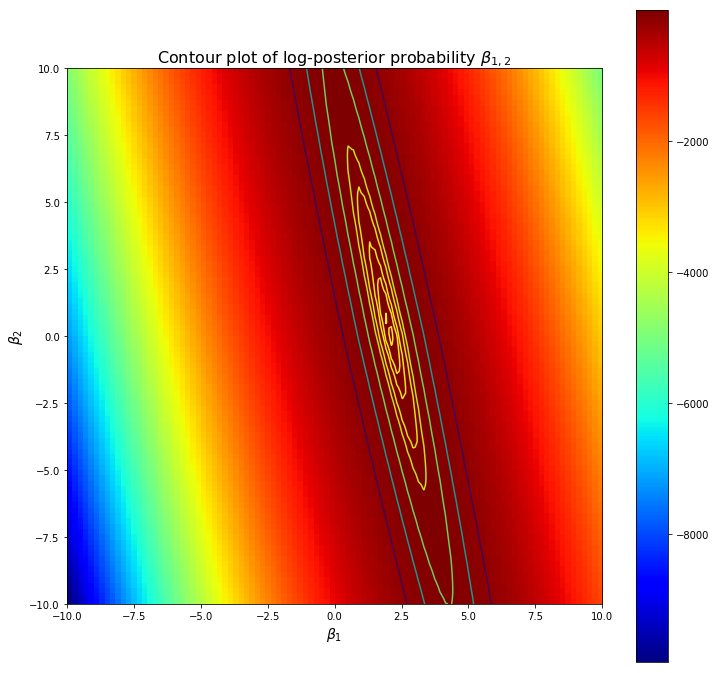

In [9]:
# re-use same data
for i,j in np.ndindex(xg.shape):
    zg[i,j] = log_model_posterior_unnorm([xg[i,j], yg[i,j]], x, y)

plt.figure(figsize=(12, 12))
plt.contour(xg, yg, zg, levels=[-160, -80, -40, -20, -15,-10, -8, -6, -5, -4, -3])
plt.imshow(zg, cmap='jet', extent=(xlim[0], xlim[1], ylim[0], ylim[1]), origin='lower')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.colorbar()
plt.title('Contour plot of log-posterior probability $\\beta_{1,2}$', fontsize=16)
plt.xlabel('$\\beta_1$', fontsize=14)
plt.ylabel('$\\beta_2$', fontsize=14)
_ = plt.show()

## A note on relationship to L1 regularization

The likelihood of the model under the Laplacian prior can be written as:

$$p(\beta_1, \beta_2 \mid x, y) \propto \exp(-|\beta_1|)\exp(-|\beta_2|) \prod_{i=1}^n \exp \left (-0.5 (y_i - (\beta_1 x_i + \beta_2))^2 \right ).$$

Thus it's log-likelihood is

$$\log p(\beta_1, \beta_2 \mid {\bf x}, {\bf y}) = C + -|\beta_1| -|\beta_2| - \sum_{i=1}^n 0.5 (y_i - (\beta_1 x_i + \beta_2))^2,$$

where $C$ is a constant independent of $\beta_{1,2}$. Recall when we search for the MAP solution we wish to find the maximum of the above, which is equivalent to minimizing

$$J(\beta_1, \beta_2) = \frac{1}{2} \sum_{i=1}^n (y_i - (\beta_1 x_i + \beta_2))^2 + |\beta_1| + |\beta_2|.$$

The last expression is the objective for L1-regularization in linear regression, where we disregarded various constants and weights. We conclude that imposing zero-centered Laplacian priors on parameters is structurally equivalent to L1 regularization.

### Exercises

1. Generalize the equations above by considering different values of the parameter $b$ of the Laplace distribution in the priors.  Where do the $b$ terms appear in the equations and what is the effect of $b$ on the L1-regularization formulation?

2. Sample from the model and draw the sampled points into the prior and into the posterior image.  How do you interpret the results?

## Conclusions

We have seen that Monte Carlo sampling results in few samples hitting the regions where model posterior is high. We should devise other methods that are more effective in finding "good regions" of the model posterior. 

## References

1. Ian Murray, Markov Chain Monte Carlo, Videolecture.net [talk](http://videolectures.net/mlss09uk_murray_mcmc/) for slides and [youtube](https://www.youtube.com/watch?v=hn0Vfzcnmig) for the talk itself.